# Music Genre Classification with CNN #

## Introduction ##

The goal of this work is to build a machine learning model able to classify samples of audio files in different music genres.

We used a Convolutional Neural Network, which performed better than most models according to the literature on the matter, even outperforming the benchmark for human accuracy, which averages around 70%.

In [122]:
import os
import sys
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#!{sys.executable} -m pip install librosa
import librosa
import librosa.display
import IPython

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import scipy.io.wavfile as wav
#!{sys.executable} -m pip install python_speech_features
from python_speech_features import mfcc
import pickle

#!{sys.executable} -m pip install tensorflow
import tensorflow as tf
from tensorflow import keras as k
from keras import layers
from keras.models import Model
from keras import regularizers
from keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

## Dataset ##

To train our model we used the GTZAN dataset, which includes:
    
* Genres original - A collection of 10 genres with 100 audio files each, all having a length of 30 seconds;
* Images original - A visual representation for each audio file. The audio files were converted to Mel Spectrograms to make this possible;
* 2 CSV files - One has for each song a mean and variance computed over multiple features that can be extracted from an audio file. The other has the same structure, but the songs were split before into 3 seconds audio files, increasing 10 times the amount of data.

The 10 genres included in our training and evaluation of the model are: 

* Classical
* Country
* Disco
* Hip-hop
* Jazz
* Metal 
* Pop
* Reggae 
* Rock


## Visual representation ## 

To recognize patterns related to music genres using CNN, a straight forward approch was to represent visual features of each sample, capturing musical differences on amplitude, frequency and energy spectrum and using the convolutional layers of the model to identify patterns within images.

Already having in the dataset the Mel Spectrograms of each audio file makes the training phase faster than having to compute it on the run. 

Nevertheless, to help us understand the data we are working on, we used the *Librosa* library, which provides the building blocks necessary to create music information retrieval systems.

In [79]:
sr = 44100 # default sampling rate is 22050: a higher sr 

metal = "Dataset/genres_original/metal/metal.00000.wav"
metal_series, sr = librosa.load(metal, sr=sr) # loads an audio file and decodes it into a 1-dimensional array which is a 
                                           # time series and its sampling rate

classical = "Dataset/genres_original/classical/classical.00000.wav"
classical_series, sr = librosa.load(classical, sr=sr)

hiphop = "Dataset/genres_original/hiphop/hiphop.00000.wav"
hiphop_series, sr = librosa.load(hiphop, sr=sr)

In [48]:
# Play samples

IPython.display.display(IPython.display.Audio(metal_series, rate=sr)) # Metal
IPython.display.display(IPython.display.Audio(classical_series, rate=sr)) # Classical
IPython.display.display(IPython.display.Audio(hiphop_series, rate=sr)) # Hip-hop

### Waveform ###

Waveform graphs plot amplitude against time. 

The amplitude indicates the strength of the vibration the sound is causing to the air. The time is the speed at which the variations are occurring. 

The shape of the wave shows the pattern of the vibration, meaning the timbre of the sound. 

Librosa's function converts a raw samples-based view of the signal to the amplitude-envelope view of the signal depending on the time extent of the plot’s viewport.

[Text(0.5, 1.0, 'Hip-hop waveform')]

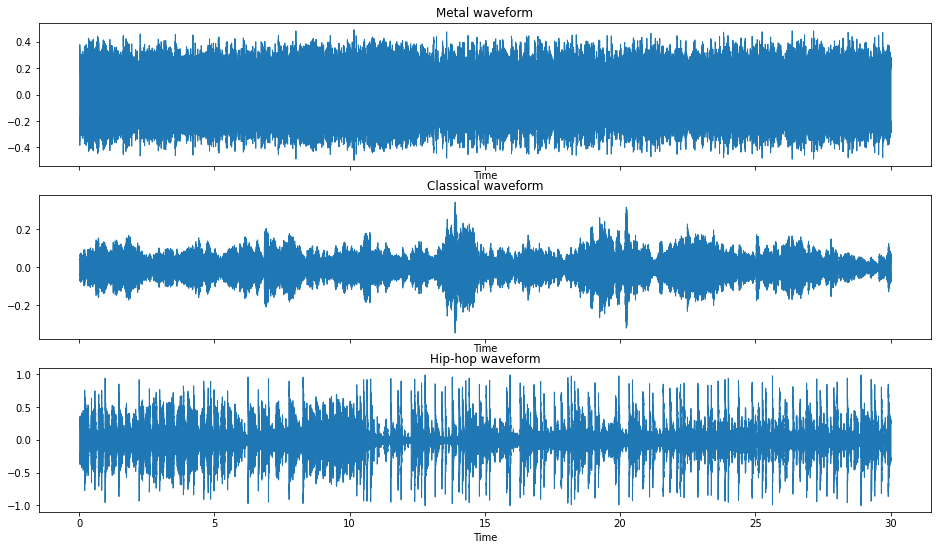

In [64]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 9), sharex=True)

# First subplot: metal
img1 = librosa.display.waveshow(metal_series, x_axis='time', ax=ax[0]) # Visualize a waveform in the time domain
ax[0].set(title='Metal waveform')

# Second subplot: classical
img2 = librosa.display.waveshow(classical_series, x_axis='time', ax=ax[1])
ax[1].set(title='Classical waveform')

# Third subplot: hip-hop
img3 = librosa.display.waveshow(hiphop_series, x_axis='time', ax=ax[2])
ax[2].set(title='Hip-hop waveform')

### Spectral Features ###

#### Mel Spectrogram ####

Mel-spectrograms are a commonly used method of featurizing audio for their close representation of human perception of audio.

A mel is a number that corresponds to a pitch, similar to how a frequency describes a pitch. The term mel comes from the word ‘melodic’ and the mel scale is intended to regularize the intervals between notes.

To convert a raw audio to mel-spectrogram, the first thing to do is to apply the short-time Fourier transforms (STFT). The STFT represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows.

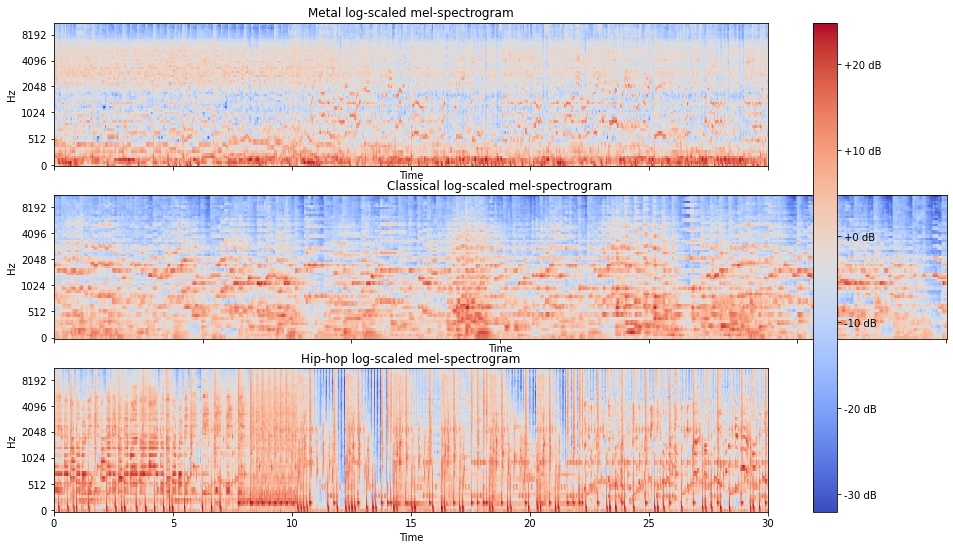

In [4]:
mel_1 = librosa.feature.melspectrogram(y=metal_series, sr=sr, n_fft=2048, hop_length=512, n_mels=64, fmax=8000)
log_mel_1 = librosa.power_to_db(mel_1)

mel_2 = librosa.feature.melspectrogram(y=classical_series, sr=sr, n_fft=2048, hop_length=512, n_mels=64, fmax=8000)
log_mel_2 = librosa.power_to_db(mel_2)

mel_3 = librosa.feature.melspectrogram(y=hiphop_series, sr=sr, n_fft=2048, hop_length=512, n_mels=64, fmax=8000)
log_mel_3 = librosa.power_to_db(mel_3)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 9), sharex=True)

# First subplot: metal
img1 = librosa.display.specshow(log_mel_1, x_axis='time', y_axis='mel', ax=ax[0])
ax[0].set(title='Metal log-scaled mel-spectrogram')

# Second subplot: classical
img2 = librosa.display.specshow(log_mel_2, x_axis='time', y_axis='mel', ax=ax[1])
ax[1].set(title='Classical log-scaled mel-spectrogram')

# Third subplot: hip-hop
img3 = librosa.display.specshow(log_mel_3, x_axis='time', y_axis='mel', ax=ax[2])
ax[2].set(title='Hip-hop log-scaled mel-spectrogram')

fig.colorbar(img1, ax=[ax[0], ax[2]], format="%+2.f dB")

#### Chromagram ####

A chromagram represents chroma-based features, used to analyze music whose pitches can be meaningfully categorized. They capture harmonic and melodic characteristics of music, while being robust to changes in timbre and instrumentation.

The underlying observation is that humans perceive two musical pitches as similar in color if they differ by an octave. Based on this observation, a pitch can be separated into two components, which are referred to as tone height and chroma.

Librosa provides functions to compute a chromagram, from a waveform or power spectrogram, which aggregates information across all frequencies corresponding to a given pitch class.

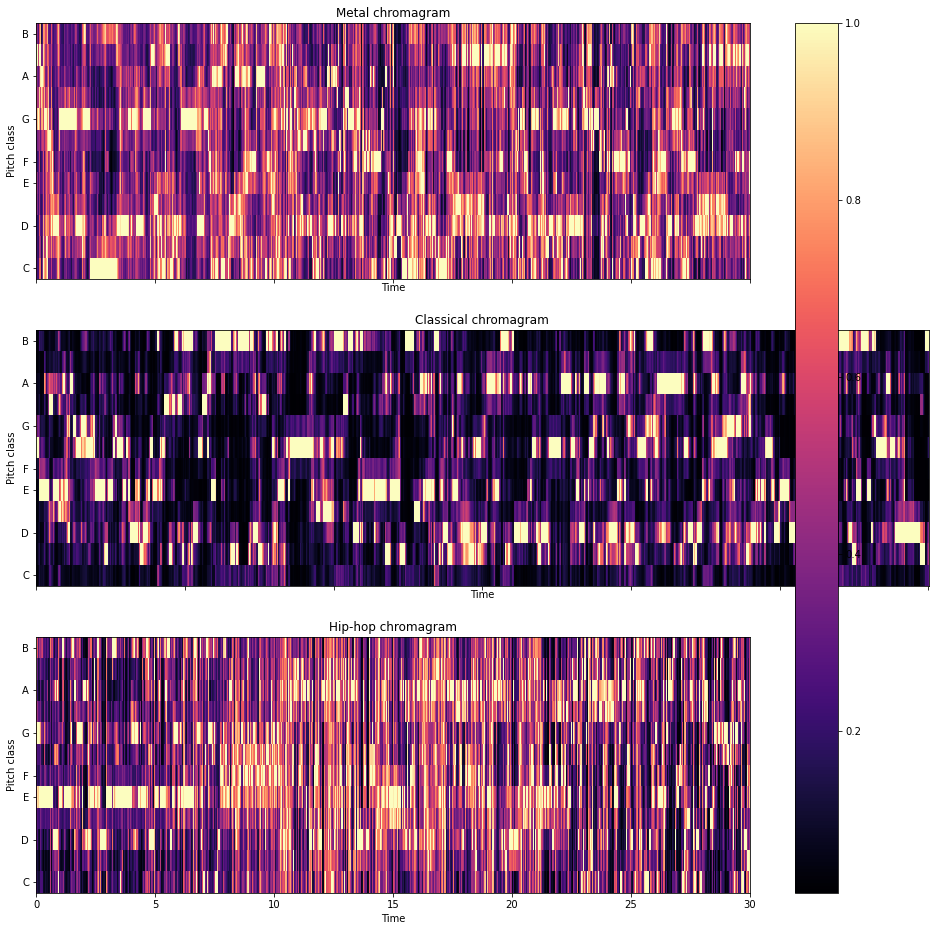

In [8]:
chroma_1 = librosa.feature.chroma_stft(y=metal_series, sr=sr) # Compute the chromagram
chroma_2 = librosa.feature.chroma_stft(y=classical_series, sr=sr)
chroma_3 = librosa.feature.chroma_stft(y=hiphop_series, sr=sr)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 16), sharex=True)

img1 = librosa.display.specshow(chroma_1, sr=sr, x_axis='time', y_axis='chroma', ax=ax[0])
ax[0].set(title='Metal chromagram')

img2 = librosa.display.specshow(chroma_2, sr=sr, x_axis='time', y_axis='chroma', ax=ax[1])
ax[1].set(title='Classical chromagram')

img3 = librosa.display.specshow(chroma_3, sr=sr, x_axis='time', y_axis='chroma', ax=ax[2])
ax[2].set(title='Hip-hop chromagram')

plt.colorbar(img1, ax=[ax[0], ax[2]])

#### Zero Crossing Rate ####

One of the main characteristics of a song that are used to classify its genre is the percussive sound. The Heel-toe technique with the double bass drum pedals is commonly used in certain subgenres of Metal, but it is highly unlikely to hear it in the other genres.

The classification of percussive sounds holds a central position in both speech recognition and music information retrieval and the zero-crossing rate is a key feature to classify percussive sounds.

Zero crossing is said to occur if successive samples have different algebraic signs, meaning that the waveform of a signal changes its sign by intersecting the zero line, where the signal is silent. The rate at which zero-crossings occur is a simple measure of the frequency content of a signal.

Zero-crossing rate is defined as the number of time-domain zero-crossings within a defined region of signal, divided by the number of samples of that region. In other words, it is a measure of number of times in a given time interval/frame that the amplitude of the speech signals passes through a value of zero.

ZCR can be utilized as a basic pitch detection algorithm for monophonic tonal signals. A large number of zero crossings implies that there is no dominant low-frequency oscillation.

To give a visual representation of how different genres have different zero-crossing rates, we used Librosa to extract the ZCR for each example track and then plot the normalized ZCR to highlight the differences.

Although the files used are quiet generical examples for their respective genre, it must be noted that ZCR may drastically change between songs of the same genre. This means that, beside a quick overview on the matter, the results must not be taken in a general way.

Text(0.5, 1.0, 'Normalized zero-crossing rates for different music genres')

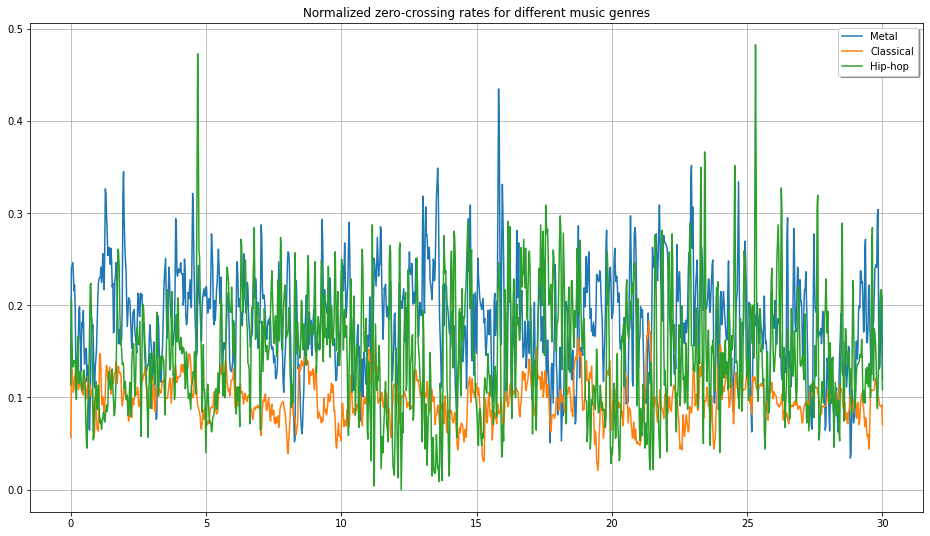

In [14]:
zcr_metal = librosa.feature.zero_crossing_rate(metal_series, frame_length=1024, hop_length=512)[0]
zcr_classical = librosa.feature.zero_crossing_rate(classical_series, frame_length=1024, hop_length=512)[0]
zcr_hiphop = librosa.feature.zero_crossing_rate(hiphop_series, frame_length=1024, hop_length=512)[0]

frames = range(len(zcr_classical))
t = librosa.frames_to_time(frames, hop_length=512)

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(t, zcr_metal, label='Metal')
ax.plot(t, zcr_classical, label='Classical')
ax.plot(t, zcr_hiphop, label='Hip-hop')

ax.legend(loc='best', shadow=True)

plt.grid()
plt.title("Normalized zero-crossing rates for different music genres")

## Features ##

### Feature extraction ###

The first step for music genre classification is features extraction from the audio files. This includes identifying the linguistic content and discarding noise.

Among the fundamental features used to categorize music genres are:

- Chroma Frequencies, used to analyze the pitch of the signal;
- Zero Crossing Rate, which describes percussive sounds;
- Spectral Centroid, which indicates where the ”centre of mass” for a sound is located in terms of the weighted mean of the frequencies present in the sound;
- Spectral Rolloff, the frequency below which a specified percentage of the total spectral energy lies;
- Mel-frequency cepstral coefficients (MFCCs), a small set of features which describe the overall shape of a spectral envelope.

These features are included in the CSV files that came along with the dataset. The list of features provided by GTZAN also includes:

- RMS amplitude, which describes the average signal amplitude;
- Spectral Bandwidth, the sum of maximum deviation of the signal on both sides of the centroid;
- Harmony;
- Tempo.

In addition, all these characteristics are computed in terms of mean and variance of the measure.

We decided to do an explicit feature extraction on the original audio files to compute the feature related to the first four characteristics described, which are the main features according to the literature used in speech and audio recognition.

Having a 'new' set of features, it should be interesting to see how the CNN performs training on the features provided by GTZAN and training on a set of fewer but important features.

In [86]:
def chroma_extractor(ts):
    chroma = librosa.feature.chroma_stft(y=ts, sr=sr)[0]
    return chroma

In [2]:
def zcr_extractor(ts):
    zcr = librosa.feature.zero_crossing_rate(ts, frame_length=1024)[0]
    return zcr

In [3]:
def spectral_centroid_extractor(ts):
    sc = librosa.feature.spectral_centroid(y=ts, sr=sr)[0]
    return sc

In [4]:
def spectral_rolloff_extractor(ts):
    sroll = librosa.feature.spectral_rolloff(y=ts, sr=sr)[0]
    return sroll

In [5]:
def mfccs_extractor(ts):
    mfccs = librosa.feature.mfcc(y=ts, sr=sr)
    return mfccs

In [83]:
def features_extractor(row):
    ts, _ = librosa.load(row, sr=sr)
    
    row = f'{np.mean(chroma_extractor(ts))} {np.mean(zcr_extractor(ts))} {np.mean(spectral_centroid_extractor(ts))} '
    row += f'{np.mean(spectral_rolloff_extractor(ts))}'
    
    for mfcc in mfccs_extractor(ts):
        row += f' {np.mean(mfcc)}'
        
    return row

In [84]:
def retrieve_features(directory, num_classes):
    header = 'filename chroma_stft zero_crossing_rate spectral_centroid spectral_rolloff'

    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()

    file = open('custom_features.csv', 'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header)
        
    i = 0
    for folder in os.listdir(directory): # genre folders
        i += 1
        if i == num_classes+1:
            break   
            
        for file in os.listdir(directory + folder): # audio files in each genre folder
            
            path = directory + folder + "/" + file
            
            row = f'{file} '
            row += features_extractor(path)
            row += f' {folder}'
            
            file = open('custom_features.csv', 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(row.split())
                
    file.close()

In [87]:
retrieve_features(directory="Dataset/genres_original/", num_classes=10)

In [17]:
#df = pd.read_csv("custom_features_30_sec.csv") # read features
df = pd.read_csv("custom_features.csv") # read features
df = df.drop(labels='filename', axis=1) # drop the first column

df.head()

chroma_stft  zero_crossing_rate  spectral_centroid  spectral_rolloff  \
0     0.398017            0.043090        1725.403862       3668.080398   
1     0.510246            0.029509        1450.067246       3291.091133   
2     0.371743            0.038988        1492.739822       2890.003999   
3     0.482102            0.017078         996.265855       1994.144477   
4     0.332407            0.051986        1749.127801       3388.157084   

        mfcc1       mfcc2      mfcc3      mfcc4      mfcc5      mfcc6  ...  \
0 -183.959549  184.188400 -44.596371  42.451725   8.526797   2.378709  ...   
1 -268.678162  172.344162 -12.678487  45.501823   6.859498   9.832589  ...   
2 -169.192993  209.051315 -48.938328  34.301708  -1.259696  -1.634195  ...   
3 -255.869278  187.662292   4.703823  28.990761  10.636995   5.686720  ...   
4 -229.943863  186.619751 -45.070690  22.179071  -7.491706 -20.724867  ...   

     mfcc12     mfcc13    mfcc14    mfcc15    mfcc16    mfcc17    mfcc18  \
0  8.086342  -6.706020  4.991573  1.707871 -1.417757  4.857560 -5.049826   
1  9.813794  -4.510671  2.344737  1.240658 -1.215105  2.714902 -6.365193   
2  6.673988  -9.913475  2.802308 -1.581411 -6.381010 -1.171352 -7.115898   
3  7.714975  -1.739321  5.085046  2.647128 -2.407381  1.094798 -1.593291   
4  0.929813 -10.900516 -4.565069 -1.346813 -7.737867 -4.851693 -7.881009   

     mfcc19    mfcc20  label  
0  0.335193  0.410662  blues  
1  0.245704  0.911158  blues  
2  1.928022 -3.268884  blues  
3  1.984655 -0.329620  blues  
4 -3.735988 -3.073222  blues  

[5 rows x 25 columns]

In [82]:
# Load images
def get_images(directory, num_classes):

    i = 0
    input_arr = []
    for folder in os.listdir(directory): # genre folders
        i += 1
        if i == num_classes+1:
            break   

        for file in os.listdir(directory + folder): # images in each genre folder

            path = directory + folder + "/" + file
            
            image = k.preprocessing.image.load_img(path)
            input_arr.append(k.preprocessing.image.img_to_array(image))

    input_arr = np.array([input_arr])  # Convert single image to a batch.
    return input_arr
            
#predictions = model.predict(input_arr)

In [84]:
input_array = get_images(directory="Dataset/images_original/", num_classes=10)

999


### Using SciKit Learn ###

The classes of this task are categorical, so there's a need to convert them into model-understandable numerical data. SciKit Learn provides the LabelEncoder class to do so. 

Moreover, SciKit Learn's StandardScaler helps in the normalization of the features, necessary to get higher performances for most classifiers.

In [18]:
class_list = df.iloc[:,-1] # Selection by position

encoder = LabelEncoder() # Encode target labels with value between 0 and n_classes-1
y = encoder.fit_transform(class_list) # Fit label encoder and return encoded labels

#fit = StandardScaler() # Standardize features by removing the mean and scaling to unit variance
#X = fit.fit_transform(np.array(df.iloc[:,:-1], dtype=float)) # Fit to data and transform it

#print(df.iloc[:,:-1]) # show which features are being used

## Model building ##

### Convolutional Neural Network ###

The CNN model works in two steps:

- Feature Extraction: various filters and layers are applied to the images to extract its information and features

- Classification: instances are classified based on the target variable of the problem.

*TensorFlow* and *Keras* provide means to implement the CNN: a convolutional window that scans over the input data and output the result of a given operation on the elements within the window. The result gets fed into a max pool layer that selects the maximum element from another window.

Models in *Keras* can come in two forms: Sequential and via the Functional API. The Sequential model allows you to easily stack sequential layers of the network in order from input to output.

A 2D convolutional layer can process 2D input images. The arguments passed to the Conv2D() layer function are:
- The number of output channels; 
- The kernel size, meaning the dimensions of the moving window; 
- The strides in the x and y directions ((1, 1) by default);
- The activation function 
- The size of the input to the layer.

A 2D max pooling layer needs specification the size of the pooling in the x and y directions and the strides (same size as the pooling by default).

The fully connected layers are defined using the Dense() layer in Keras, which specify the number of nodes and their activation function.  

The output layer is a soft-max classification the size of the number of our classes.

#### Architecture ####

A common architectural pattern for CNNs is structued in:

- A sequence of a CONV layer, followed by a RELU layer and a sequence of POOL layers. This is repeated until a sufficiently small output is reached;

- A sequence of a FC layer, followed by a RELU layer and, finally, an output FC layer, that gives the scores related to each class.

According to a *transfer learning* approach, we didn't build a CNN from scratch, but we studied popular models with high perfomances to use with our dataset.

#### Huang ####

In a paper of 2018, Derek Huang et al. analyze the performance on the same dataset that we use here of four types of models: KNN, SVM, FFNN and CNN. 

As they say in the paper, the CNN is the one which performed better among the four and it is the one that we analyze here.

The architecture consists of 3 convolutional layers, each with its own max pool and regularization, feeding into m fully connected layers with ReLU activation, softmax output and cross entropy loss.

The first convolution window was set to be 4x4 and the optimizer used was Adam.

In [123]:
# Huang Architecture
def cnn(num_genres=10, input_shape=(64,173,1)):
    
    cnn = k.models.Sequential([
        
        # 2D convolution layer (e.g. spatial convolution over images)
        k.layers.Conv2D(64, kernel_size=(4, 4), activation='relu', input_shape=input_shape), 
        
        # applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1
        k.layers.BatchNormalization(), 
        
        # Max pooling operation for 2D spatial data
        k.layers.MaxPooling2D(pool_size=(2, 4)), 
        
        k.layers.Conv2D(64, (3, 5), activation='relu', kernel_regularizer=regularizers.l2(0.04)),
        k.layers.MaxPooling2D(pool_size=(2, 2)), 
        
        # Applies Dropout to the input
        k.layers.Dropout(0.2),
        
        k.layers.Conv2D(64, (2, 2), activation='relu'),
        k.layers.BatchNormalization(),
        k.layers.MaxPooling2D(pool_size=(2, 2)), 
        k.layers.Dropout(0.2),
        
        # Flattens the input
        k.layers.Flatten(),
        
        # Fully connected layer
        k.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.04)),
        
        k.layers.Dropout(0.5),
        k.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.04)),
        k.layers.Dense(10, activation='softmax')
    ])
    
    return cnn

#### AlexNet ####

AlexNet architecture is liable by the use of two GPUs to train the model. It is built in the following way:

- Its input is 224x224x3 images.
- 96 convolutions of 11x11 with a stride of 4. Response normalization and pooling applied on the out of the layer, then the network splits into two identical stems until fully connected.
- 256 filters of 5x5 each which are then again response normalized and pooled.
- Three different layers with 384 kernels of 3x3 each.
- Rather having a singular representation of 4096 neurons, the authors had to divide it into 2 parts, 2048 each. Each part is fed data from both stems.
- The fully connected layer is again repeated while getting data from both stems.
- Finally, a Dense layer with softmax activation is the output layer.

In this architecture there are a few successfull ideas:

- Local Response Normalization: it brings out those activations that are performing much better w.r.t. its neighbours, increasing the efficiency of the network as some neurons will be acting as the core of the network. Furthermore, it helps diminishing redundant features.

- Overlapping Pooling: differently from non-overlapping pooling some areas where the density of low values is high will also be conserved, so that the spatial information will be conserved more and the network won’t overfit easily. 

- Data Augmentation: AlexNet uses image translations and horizontal reflection and PCA to extract the principal components for each of the RGB channels and add a random fraction of these principal components into each pixel of the image, altering the colour and intensity of the illumination.

- Dropout: the de facto method to reduce overfitting in neural networks, randomly switching off some neurons, so that each neuron is forced to learn features that are not dependent on its neighbours, thus leading to more robust features.
    
To list other meaningful hyperparameters:

- As optimizer they have used SGD with momentum of 0.9 which needs a proper training schedule and is thus hard to train. So, the de facto optimizer is Adam.

- The training batch size is 128, which is good and in line with all the advice about deep learning.

- Weight decay also has been used with a value at 0.0005.

- Weight initialization is done using zero-mean Gaussian distribution with a standard deviation of 0.01. In case of bias initialization, they have initialized the biases with 1 from the second dense layer onwards while other layers’ biases are initialized with 0. This initialization helps the network initially by giving ReLU positive inputs.

- Learning rate was set initially at 0.01 and reduced by a factor of 10 whenever the validation error rate stopped improving.

In [122]:
# AlexNet Architecture
def cnn():
    
    cnn = k.models.Sequential([
        k.layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', 
                        kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01), 
                        input_shape=(224, 224, 3)),
        k.layers.MaxPooling2D(3, strides=2),
        k.layers.Conv2D(256, (5, 5), activation='relu', 
                        kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01), 
                        bias_initializer='ones'),
        k.layers.MaxPooling2D(3, strides=2),
        k.layers.Conv2D(384, (3, 3), activation='relu', 
                        kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01)),
        k.layers.Conv2D(384, (3, 3), activation='relu', 
                        kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01),
                        bias_initializer='ones'),
        k.layers.Conv2D(384, (3, 3), activation='relu', 
                        kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01), 
                        bias_initializer='ones'),
        k.layers.MaxPooling2D(3, strides=2),
        k.layers.Flatten(),
        k.layers.Dense(4096, 
                       kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01), 
                       bias_initializer='ones'),
        k.layers.Dropout(0.5),
		k.layers.Dense(4096, 
                       kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01), 
                       bias_initializer='ones'),
        k.layers.Dropout(0.5),
        k.layers.Dense(10, activation='softmax', 
                       kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01))
	])
    
    return cnn

#### GoogLeNet ####

In [184]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
    """
    f1: number of filters of the 1x1 convolutional layer in the first path
    f2_conv1, f2_conv3: number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
    f3_conv1, f3_conv5: number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
    f4: number of filters of the 1x1 convolutional layer in the fourth path
    """
    # 1st path:
    path1 = k.layers.Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

    # 2nd path
    path2 = k.layers.Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path2 = k.layers.Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

    # 3rd path
    path3 = k.layers.Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path3 = k.layers.Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

    # 4th path
    path4 = k.layers.MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
    path4 = k.layers.Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

    output_layer = k.layers.add([path1, path2, path3, path4])

    return output_layer

In [185]:
def cnn():

    # input layer 
    input_layer = k.layers.Input(shape = (224, 224, 3))

    # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
    X = k.layers.Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = k.layers.MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # convolutional layer: filters = 64, strides = 1
    X = k.layers.Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

    # convolutional layer: filters = 192, kernel_size = (3,3)
    X = k.layers.Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = k.layers.MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 1st Inception block
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

    # 2nd Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = k.layers.MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 3rd Inception block
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

    # Extra network 1:
    X1 = k.layers.AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X1 = k.layers.Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
    X1 = k.layers.Flatten()(X1)
    X1 = k.layers.Dense(1024, activation = 'relu')(X1)
    X1 = k.layers.Dropout(0.7)(X1)
    X1 = k.layers.Dense(5, activation = 'softmax')(X1)


    # 4th Inception block
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 5th Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 6th Inception block
    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

    # Extra network 2:
    X2 = k.layers.AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X2 = k.layers.Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
    X2 = k.layers.Flatten()(X2)
    X2 = k.layers.Dense(1024, activation = 'relu')(X2)
    X2 = k.layers.Dropout(0.7)(X2)
    X2 = k.layers.Dense(1000, activation = 'softmax')(X2)


    # 7th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = k.layers.MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # 8th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

    # 9th Inception block
    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

    # Global Average pooling layer 
    X = k.layers.GlobalAveragePooling2D(name = 'GAPL')(X)

    # Dropoutlayer 
    X = k.layers.Dropout(0.4)(X)

    # output layer 
    X = k.layers.Dense(1000, activation = 'softmax')(X)

    # model
    cnn = k.models.Model(input_layer, [X, X1, X2], name = 'GoogLeNet')
    
    return cnn

### Training ###

As a validation approach, k-fold cross-validation is often used for simple models with few parameters, simple hyperparameters and models that are easy to optimize (e.g. linear regression, logistic regression, small neural networks and support vector machines).

For a convolutional neural network with many parameters (e.g. more than one million) we just have too many possible changes in the architecture, since the experiments may focus on learning rate, batch size, dropout (amount and position) and batch normalization (position). 

Given this premise, it can be simpler to split training and test set by percentage.

In [202]:
# Architecture 1: 5 layers, 20% dropout per layer
def cnn():
    cnn = k.models.Sequential([k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)), 
                               k.layers.Dropout(0.2),
                               k.layers.Dense(256, activation='relu'), 
                               k.layers.Dropout(0.2),
                               k.layers.Dense(128, activation='relu'), 
                               k.layers.Dropout(0.2),
                               k.layers.Dense(64, activation='relu'), 
                               k.layers.Dropout(0.2),
                               k.layers.Dense(10, activation='softmax')])

    return cnn

In [124]:
dataset = k.utils.image_dataset_from_directory(directory="Dataset/images_original", batch_size=None)

Found 999 files belonging to 10 classes.


In [125]:
def get_dataset_partitions(dataset, dataset_size, train_split=0.8, val_split=0.1, test_split=0.1):

    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    test_size = int(test_split * dataset_size)
    
    dataset = dataset.shuffle(dataset_size)
    
    train = dataset.take(train_size)
    test = dataset.skip(train_size)
    val = test.skip(val_size)
    test = test.take(test_size)

    X_train, Y_train = zip(*train)
    X_val, Y_val = zip(*val)
    X_test, Y_test = zip(*test)

    # One-Hot encoding for classes: convert classes into categorical vectors
    Y_train = np.array(k.utils.to_categorical(Y_train, 10))
    Y_val = np.array(k.utils.to_categorical(Y_val, 10))
    Y_test = np.array(k.utils.to_categorical(Y_test, 10))
    
    return (X_train, Y_train), (X_val, Y_val), (X_test, Y_test)

In [126]:
#X_train, X_test, y_train, y_test = train_test_split(input_array, y, test_size=0.33)
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = get_dataset_partitions(dataset, dataset_size=999)

*Keras* supplies many loss functions and optimizers. 

In this case, we will use the standard cross entropy for categorical class classification (sparse_categorical_crossentropy is similar to categorical_crossentropy just used when we have multiple classification fields) and the Adam optimizer that mitigates the sparse gradient problem of two dimensional time-series, maintaining a per-parameter learning rate, and the noise problem of audio data, basing updates on a weighted average of recent updates.

The metric evaluated to describe the performance of the model is accuracy.

The fit() command takes all training data (x_train and y_train), the batch size, the number of training epochs, the callbacks and the validation data.

Callbacks can be useful to track the training process. Here, we used the EarlyStopping class in *Keras* to stop the training when a certain metric (the loss on the validation set) doesn't improve after a certain number of epochs (100). This helps in avoiding useless computational effort and waste of time.

In [101]:
def training(model, training, labels, validation, epochs, optimizer, loss, metrics):
    
    # stop training when a loss on test has stopped improving
    early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1) 
    
    model.compile(optimizer, loss, metrics)
    
    return model.fit(training, labels, batch_size=128, epochs=epochs, callbacks=[early_stopping], validation_data=validation)

In [120]:
def reshape_input(x, y, z, X_train, X_val, X_test):
    # Reshape for CNN architecture
    X_train = np.array([a.reshape((x, y, z)) for a in X_train])
    X_val = np.array([a.reshape((x, y, z)) for a in X_val])
    X_test = np.array([a.reshape((x, y, z)) for a in X_test])
    
    return X_train, X_val, X_test

In [121]:
X_train, X_val, X_test = reshape_input(64, 173, 1, X_train, X_val, X_test) # Huang

cnn = cnn()
print(cnn.summary())

trained_cnn = training(cnn, X_train, Y_train, validation=(X_val, Y_val),
                       epochs=1000, optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

AttributeError: EagerTensor object has no attribute 'reshape'. 
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()
      

In [193]:
def plot_validate(history):
    print("Validation Accuracy", max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

Validation Accuracy 0.9278131723403931


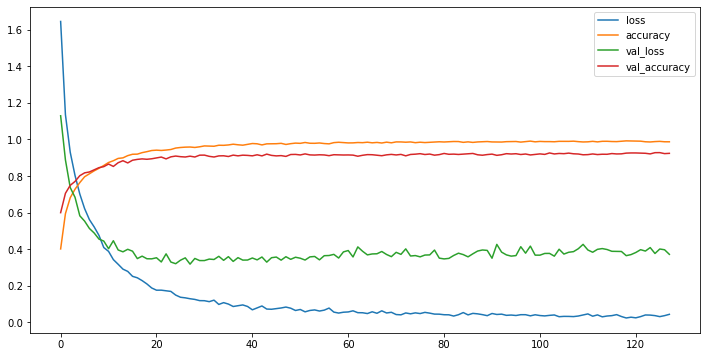

In [206]:
plot_validate(trained_cnn)

### Model Evaluation ###

To help understand the performance of the model, other than showing its metrics, the confusion matrix is quite self-explanatory, due to the uniform distribution of the classes on the dataset.

In [97]:
test_loss, test_acc = cnn.evaluate(X_test, y_test, batch_size=128) # get the accuracy

26/26 [==============================] - 0s 3ms/step - loss: 0.5190 - accuracy: 0.9296


In [98]:
y_pred = cnn.predict(X_test) # percentage by how much that music matches to each genre
np.argmax(y_pred[0])

# cm = confusion_matrix(y_test, y_pred)
#f = sns.heatmap(cm, annot=True, fmt='d')

104/104 [==============================] - 0s 2ms/step


3

In [99]:
print("\nTest loss: ", test_loss)
print("\nTest accuracy: ", test_acc*100)


Test loss:  0.5189849734306335

Test accuracy:  92.96330213546753


## Conclusion ##

## References ##

1. D. A. Huang, A. A. Serafini, E. J. Pugh. Music Genre Classification. 2018. Standford University.
2. Librosa. https://librosa.org/doc/latest/index.html
3. GTZAN. https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification?resource=download
4. F. Gouyon, F. Pachet, O. Delerue. On the use of zero-crossing rate for an application of classification of percussive sounds. 2000.
5. Keras. https://keras.io/
6. https://medium.datadriveninvestor.com/five-powerful-cnn-architectures-b939c9ddd57b
7. R. Basili, A. Serafini, A. Stellato. Classification of musical genre: a machine learning approach. University of Rome Tor Vergata.
8. https://towardsdatascience.com/extract-features-of-music-75a3f9bc265d